In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! unzip -q '/content/drive/My Drive/Colab Notebooks/train.zip' -d dataset
! unzip -q '/content/drive/My Drive/Colab Notebooks/test.zip' -d dataset

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

In [9]:
EPOCHS = 100
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 201

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.0003
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [10]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [16]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(2048, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(512, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
    
for i in range(len(vgg_notop.layers)):
    vgg_notop.layers[i].trainable = False

softmax_out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, softmax_out)
model.load_weights('/content/drive/MyDrive/model/Senet50/senet50-weights-best.h5')
svm_out = Dense(7, use_bias=False, activation='linear', name='svm')(x)
model2 = Model(input=model.input, output=[svm_out])

cp_filepath='/content/drive/MyDrive/Colab Notebooks/senet50-weights-best.h5'
optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model2.compile(optimizer=sgd, loss=svm_loss(model2.get_layer('svm')), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(path, split=False):
    if split:
      datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
      return datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS,
              subset='training'), datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS,
              subset='validation')
    else:
      datagen = ImageDataGenerator(rescale=1./255)
      return datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS), None

In [13]:
train_generator, validation_generator  = load_data('/content/train', True)
test_generator, _  = load_data('/content/test')

Found 17631 images belonging to 7 classes.
Found 4404 images belonging to 7 classes.
Found 5512 images belonging to 7 classes.


In [17]:
history = model2.fit_generator(
    generator = train_generator,
    validation_data=validation_generator, 
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop, checkpoint],
    # use_multiprocessing=True,
) 

Epoch 1/100
276/276 [==============================] - 39s 140ms/step - loss: 3.8714 - accuracy: 0.6114 - val_loss: 1.7388 - val_accuracy: 0.6297

Epoch 00001: val_accuracy improved from -inf to 0.62965, saving model to /content/drive/MyDrive/Colab Notebooks/senet50-weights-best.h5
Epoch 2/100
276/276 [==============================] - 36s 132ms/step - loss: 0.8816 - accuracy: 0.7933 - val_loss: 0.5741 - val_accuracy: 0.6317

Epoch 00002: val_accuracy improved from 0.62965 to 0.63170, saving model to /content/drive/MyDrive/Colab Notebooks/senet50-weights-best.h5
Epoch 3/100
276/276 [==============================] - 36s 132ms/step - loss: 0.3566 - accuracy: 0.8127 - val_loss: 0.4053 - val_accuracy: 0.6306

Epoch 00003: val_accuracy did not improve from 0.63170
Epoch 4/100
276/276 [==============================] - 36s 132ms/step - loss: 0.2565 - accuracy: 0.8139 - val_loss: 0.3185 - val_accuracy: 0.6301

Epoch 00004: val_accuracy did not improve from 0.63170
Epoch 5/100
276/276 [======

In [20]:
print('\n# Evaluate on validation data')
results_validation = model2.evaluate_generator(validation_generator, 4407 // BS)
print('validation loss, validation acc:', results_validation)


# Evaluate on validation data
validation loss, validation acc: [0.283564954996109, 0.6295955777168274]


In [22]:
print('\n# Evaluate on test data')
results_test = model2.evaluate_generator(test_generator, 5512 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.3483980894088745, 0.6277253031730652]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


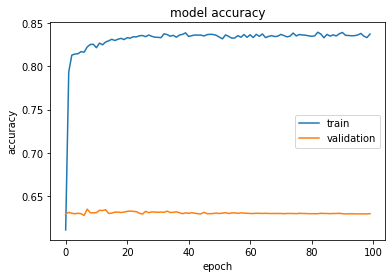

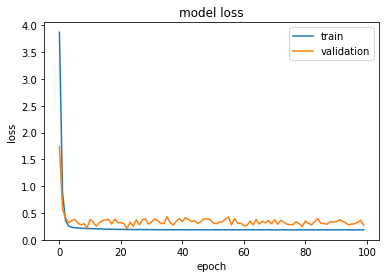

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [24]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Colab Notebooks/' + 'SESNET50' + epoch_str + test_acc + '.h5')